In [1]:
#TEST

In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import Estimate
import figure 
from EconModel import cpptools
import pickle

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)


plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings

do_compile = True
threads = 20
T = 20


In [3]:
name = 'model_FC'
model_name = "model_FC"
do_distr_yerror = "none"
do_yerror = 0
name_error = f'{do_distr_yerror}{do_yerror}std_Yerror'
#N = 16000 #MODEL_LC 
#N = 4000 #model NC
N = 9000
#name_error = "uni2std_Yerror"

specs = {}
#specs.update({f'test2':{'latexname':'limited', 'par':{ 'T':T, 'num_K': 5, 'num_A': 10 ,  'do_HK': False, 'threads':threads,'bargaining':0}}})


#specs.update({f'model_LC':{'latexname':'limited', 'par':{ 'T':T, 'do_HK': False, 'simN': N,  'threads':threads,'bargaining':1}}})
#specs.update({f'model_NC':{'latexname':'limited', 'par':{ 'T':T, 'do_HK': False, 'simN': N,  'threads':threads,'bargaining':2}}})
specs.update({f'model_FC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'simN': N,  'threads':threads,'bargaining':0}}})

# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    
    # setup model
    model = LimitedCommitmentModelClass(name=name,par=spec['par'])
    model.spec = spec

    compile_now = True if do_compile & (m==0) else False
    model.link_to_cpp(force_compile=compile_now)
    

# setup model
#model = LimitedCommitmentModelClass(name=name)    
#model.link_to_cpp(force_compile=True)


#load par and sol
pickle_file = f'output/{name}_sol.pickle'

with open(pickle_file, 'rb') as f:
    model.sol = pickle.load(f)

pickle_file = f'output/{name}_par.pickle'

with open(pickle_file, 'rb') as f:
    model.par = pickle.load(f)
    model.par.simN = N

In [4]:
data = Estimate.create_data(model,start_p = 2, end_p = model.par.T-2, yerror = do_distr_yerror, scale_st = do_yerror )
data = Estimate.create_variable(data, model.par)
data = Estimate.aux_est(data,model.par)

data2 = data

#data2 = data2[data2['delta_log_barganing']< 0.5]
#data2 = data2[data2['delta_log_barganing']> -0.5]
#data2 = data2[data2['delta_log_barganing']!= 0]


_, wald_FC_w , wald_NC_w,  _,_,_ = Estimate.main_est(data2,gender= "w", do_estimate_wage = "est_omega", print_reg = True, shadow_value_simple=2, do_control_love = False)
   

c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:205: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[delta_log] = data[log_name]-data[log_name_l]
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[delta_log_l] = data[log_name_l]-data[log_name_l2]
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:207: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

                            OLS Regression Results                            
Dep. Variable:                    y_w   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     450.1
Date:                Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                        10:29:24   Log-Likelihood:                 25134.
No. Observations:                9568   AIC:                        -4.983e+04
Df Residuals:                    9347   BIC:                        -4.824e+04
Df Model:                         220                                         
Covariance Type:              cluster                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3351 

In [5]:
#SUMMARIZE!! TORSDAG!!  N = 5000, FC: 5066 NC: 19,000 , LC: 21,000
data2 = Estimate.create_data(model,start_p = 2, end_p = model.par.T-2, yerror = do_distr_yerror, scale_st = do_yerror )
data2 = Estimate.create_variable(data2, model.par)
data2['BMI_w']=data2['BMI_w']-1
data2['BMI_m']=data2['BMI_m']-1
summary = data2[['hours_w','hours_m','cons','wage_w','wage_m','earnings_w','earnings_m','wealth','BMI_w','BMI_m','barganing']].describe()
summary_by_T = data2[['hours_w','hours_m','cons','wage_w','wage_m','earnings_w','earnings_m','wealth','BMI_w','BMI_m','barganing','t']].groupby('t').mean()
summary_by_T['div_share'] = 1-data2[['hours_w','t']].groupby('t').count()/N

print(summary)
print(summary_by_T)

summary.to_excel(f'summary_statistics_{name}.xlsx')
summary_by_T.to_excel(f'summary_statistics_byT_{name}.xlsx')

#print(summary_by_count)

c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:205: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[delta_log] = data[log_name]-data[log_name_l]
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:206: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[delta_log_l] = data[log_name_l]-data[log_name_l2]
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:207: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

            hours_w       hours_m          cons        wage_w        wage_m  \
count  15127.000000  15127.000000  15127.000000  15127.000000  15127.000000   
mean       0.833171      0.832738      1.465145      1.513649      1.513183   
std        0.115602      0.116037      0.182225      0.092184      0.091061   
min        0.379370      0.362264      0.928447      1.221107      1.224573   
25%        0.763020      0.764959      1.331013      1.449274      1.449284   
50%        0.852582      0.851113      1.495390      1.509563      1.510051   
75%        0.921473      0.922061      1.606191      1.574610      1.573219   
max        1.000000      1.000000      1.997756      1.930502      1.903488   

         earnings_w    earnings_m        wealth         BMI_w         BMI_m  \
count  15127.000000  15127.000000  15127.000000  15127.000000  15127.000000   
mean       1.262221      1.261424      3.850608      0.134594      0.150129   
std        0.199148      0.200692      1.142608    

C:\Users\czk481\AppData\Local\Temp\2\ipykernel_11932\3342145127.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2['rel_dif_hours_w']=data2['delta_hours_w']/data2['hours_w_l']
C:\Users\czk481\AppData\Local\Temp\2\ipykernel_11932\3342145127.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2['hours_w_limit100'] = (data2['hours_w'] == 1)
C:\Users\czk481\AppData\Local\Temp\2\ipykernel_11932\3342145127.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

       hours_w_limit97   hours_w  hours_m_limit  barganing
0                    1  0.999299              0   0.243427
1                    1  0.999353              0   0.243427
2                    1  1.000000              0   0.243427
3                    1  0.999284              0   0.243427
4                    1  0.991827              0   0.243427
...                ...       ...            ...        ...
15122                0  0.853276              0   0.502870
15123                0  0.928020              0   0.502870
15124                0  0.863701              0   0.502870
15125                0  0.907755              0   0.502870
15126                0  0.930754              0   0.502870

[15127 rows x 4 columns]
       rel_dif_hours_w  delta_hours_w     hours_w_l  hours_w_limit100  \
count     15127.000000   15127.000000  15127.000000      15127.000000   
mean         -0.011915      -0.012686      0.845858          0.006743   
std           0.086750       0.069215      0.11

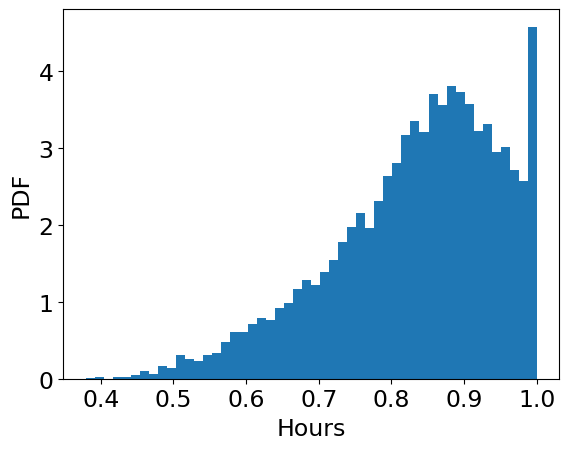

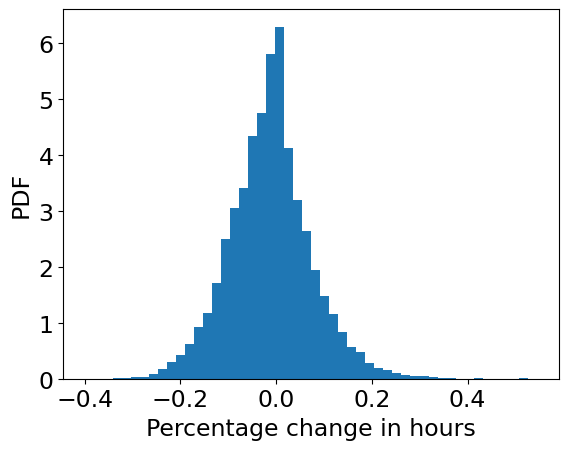

In [6]:
#kig på ændring i hours

gender = "w"

data2['rel_dif_hours_w']=data2['delta_hours_w']/data2['hours_w_l']

#kig på andel af par hvor en arbejder fuldtid


#stor en adnel er ved 1 

data2['hours_w_limit100'] = (data2['hours_w'] == 1)
data2['hours_w_limit100'] = data2['hours_w_limit100'].replace({True: 1, False: 0})
data2['hours_w_limit97'] = (data2['hours_w'] > 0.97)
data2['hours_w_limit97'] = data2['hours_w_limit97'].replace({True: 1, False: 0})

data2['hours_w_limit90'] = (data2['hours_w'] > 0.90)
data2['hours_w_limit90'] = data2['hours_w_limit90'].replace({True: 1, False: 0})

data2['hours_m_limit'] = (data2['hours_m'] > 0.97)
data2['hours_m_limit'] = data2['hours_m_limit'].replace({True: 1, False: 0})


print(data2[['hours_w_limit97','hours_w','hours_m_limit','barganing']])



summary = data2[['rel_dif_hours_w','delta_hours_w','hours_w_l', 'hours_w_limit100', 'hours_w_limit97', 'hours_w_limit90']].describe([.01,.1,.25,.5,.75,.9,.99])
print(summary)
#antag små ændringer er + - 10%

plt.hist(data2['hours_w'], bins = 50, density = True)
plt.xlabel('Hours')
plt.ylabel('PDF')
plt.savefig(f'output/hours_plot{model_name}_{gender}.png')
plt.show()

data3 = data2
data3=data3.drop(data3[(data3['hours_w_l']>0.9999) | (data3['hours_m_l']>0.9999) | (data3['hours_w']>0.9999) | (data3['hours_m']>0.9999)].index)

plt.hist(data2['rel_dif_hours_w'], bins = 50, density = True)
plt.xlabel('Percentage change in hours')
plt.ylabel('PDF')

plt.savefig(f'output/change_in_hours_plot{model_name}_{gender}.png')
#plt.hist(data3['rel_dif_hours_w'], bins = 50)
plt.show()
